# Classification

In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('df_new_dummies.csv')
df.head()

,Loan Status,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,...,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_other
0,Fully Paid,11520.0,741.0,33694.0,584.03,12.3,10,0,6760,16056.0,...,0,0,0,1,0,0,0,0,0,0
1,Fully Paid,3441.0,734.0,42269.0,1106.04,26.3,17,0,6262,19149.0,...,0,0,0,0,0,0,0,0,0,1
2,Fully Paid,21029.0,747.0,90126.0,1321.85,28.8,5,0,20967,28335.0,...,0,0,0,1,0,0,0,0,0,0
3,Fully Paid,18743.0,747.0,38072.0,751.92,26.2,9,0,22529,43915.0,...,0,0,0,1,0,0,0,0,0,0
4,Fully Paid,11731.0,746.0,50025.0,355.18,11.5,12,0,17391,37081.0,...,0,0,0,1,0,0,0,0,0,0


## 1. Classification with all available variables

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [4]:
X=df.drop(['Loan Status'], axis=1)
y=df['Loan Status']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# here, LogisticRegression is applied without the parameter class_weight='balanced'

In [6]:
c_space = np.logspace(-5, 8, 15)
param_grid={'C': c_space, 'penalty':['l2']} # [l1,'l2']
logreg = LogisticRegression(max_iter=10000)
logreg_cv = GridSearchCV(logreg, param_grid, cv=5);
logreg_cv.fit(X_train, y_train);

In [7]:
logreg_cv.best_params_

{'C': 1e-05, 'penalty': 'l2'}

In [8]:
logreg_cv.best_score_

0.6326561005087187

In [9]:
best_model = logreg_cv.best_estimator_

In [10]:
y_pred = best_model.predict(X_test)

In [11]:
y_pred_proba=best_model.predict_proba(X_test)

In [12]:
# wrestle data to create plots:
# here I create two subsets of probabilities, one for cases that were 'Fully Paid' and 
# correctly identified as such, and one for 'Charged Off' and correctly identified as such
pred_proba_df=pd.DataFrame(data=y_pred_proba, columns=['Charged Off','Fully Paid'])
pred_proba_df['True']=y_test.values

subset_1=pred_proba_df[pred_proba_df['True']=='Fully Paid']['Fully Paid']
subset_2=pred_proba_df[pred_proba_df['True']=='Charged Off']['Charged Off']

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math

%matplotlib inline

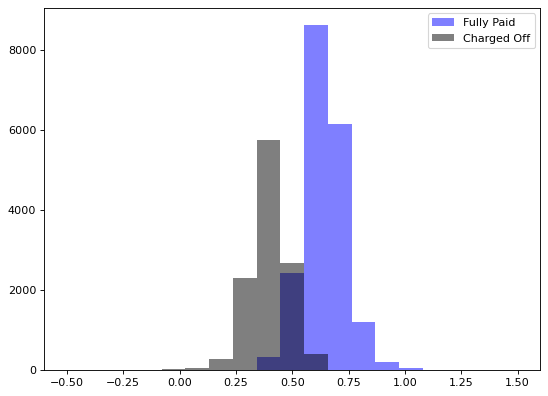

In [14]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
bins = np.linspace(-0.5, 1.5, 20)

plt.hist(subset_1, bins, color="b", alpha=0.5, label='Fully Paid')
plt.hist(subset_2, bins, color="k",alpha=0.5,label='Charged Off')
plt.legend(loc='upper right')
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test, y_pred)

array([[ 1317, 10168],
       [ 1091, 17890]], dtype=int64)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.55      0.11      0.19     11485
  Fully Paid       0.64      0.94      0.76     18981

    accuracy                           0.63     30466
   macro avg       0.59      0.53      0.48     30466
weighted avg       0.60      0.63      0.55     30466



#### Addition of categorial variables as dummies did not improve the model. In fact, the confusion matrix contains three less correctly identified 'Charged Off' cases

In [17]:
import shap
shap.initjs()

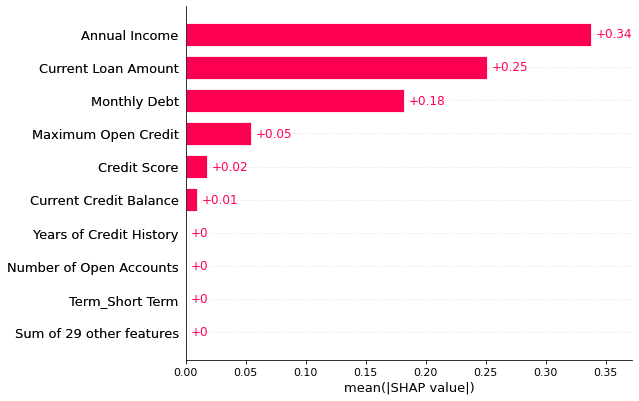

In [18]:
model = best_model
model.fit(X_train, y_train)

def model_proba(x):
    return model.predict_proba(x)[:,1]
def model_log_odds(x):
    p = model.predict_log_proba(x)
    return p[:,1] - p[:,0]

# compute SHAP values for linear
background = shap.maskers.Independent(X_train, max_samples=100)

# compute SHAP values
explainer = shap.Explainer(model, background)
shap_values = explainer(X_train)

shap.plots.bar(shap_values) # use mean absolute value of each feature over all the instances

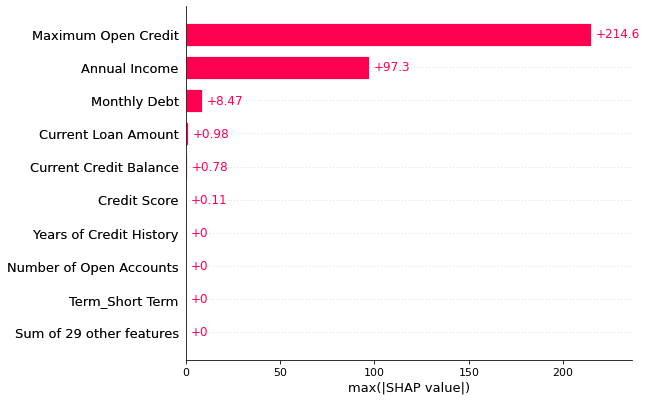

In [19]:
shap.plots.bar(shap_values.abs.max(0)) # use max absolute value 

In [20]:
# Important variables: Annual Income, Current Loan Amount, Monthly Debt, Maximum Open Credit, Credit Score, Current Credit balance.
# None of the categorical values are useful

## 2. Standardize with RobustScaler (strong against outliers), balanced class size

In [21]:
### default solver; C in (-5, 8, 15)

In [22]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

In [23]:
X.loc[:,'Current Loan Amount':'Tax Liens']

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,11520.0,741.0,33694.0,584.03,12.3,10,0,6760,16056.0,0.0,0.0
1,3441.0,734.0,42269.0,1106.04,26.3,17,0,6262,19149.0,0.0,0.0
2,21029.0,747.0,90126.0,1321.85,28.8,5,0,20967,28335.0,0.0,0.0
3,18743.0,747.0,38072.0,751.92,26.2,9,0,22529,43915.0,0.0,0.0
4,11731.0,746.0,50025.0,355.18,11.5,12,0,17391,37081.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
152325,11953.0,717.0,39844.0,982.82,11.7,9,1,4176,4783.0,1.0,0.0
152326,5078.0,737.0,77186.0,1376.47,19.1,9,0,1717,9758.0,0.0,0.0
152327,12116.0,746.0,52504.0,297.96,15.1,8,0,3315,20090.0,0.0,0.0
152328,12116.0,746.0,52504.0,297.96,15.1,8,0,3315,20090.0,0.0,0.0


In [24]:
transformer = RobustScaler().fit(X.loc[:,'Current Loan Amount':'Tax Liens'])

In [25]:
X.loc[:,'Current Loan Amount':'Tax Liens']=transformer.transform(X.loc[:,'Current Loan Amount':'Tax Liens'])

In [26]:
X

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,...,Purpose_Business Loan,Purpose_Buy House,Purpose_Buy a Car,Purpose_Debt Consolidation,Purpose_Educational Expenses,Purpose_Home Improvements,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_other
0,-0.054291,0.363636,-0.662264,-0.380997,-0.555556,0.000000,0.0,-0.333228,-0.244571,0.0,...,0,0,0,1,0,0,0,0,0,0
1,-0.745572,0.151515,-0.458177,0.345361,1.172840,1.166667,0.0,-0.370423,-0.111227,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0.759348,0.545455,0.680828,0.645653,1.481481,-0.833333,0.0,0.727887,0.284794,0.0,...,0,0,0,1,0,0,0,0,0,0
3,0.563746,0.545455,-0.558066,-0.147384,1.160494,-0.166667,0.0,0.844552,0.956468,0.0,...,0,0,0,1,0,0,0,0,0,0
4,-0.036237,0.515152,-0.273583,-0.699433,-0.654321,0.333333,0.0,0.460797,0.661845,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152325,-0.017241,-0.363636,-0.515893,0.173905,-0.629630,-0.166667,1.0,-0.526225,-0.730565,1.0,...,0,0,0,1,0,0,0,0,0,0
152326,-0.605502,0.242424,0.372854,0.721655,0.283951,-0.166667,0.0,-0.709887,-0.516086,0.0,...,0,0,0,1,0,0,0,0,0,0
152327,-0.003294,0.515152,-0.214582,-0.779053,-0.209877,-0.333333,0.0,-0.590533,-0.070659,0.0,...,0,0,0,1,0,0,0,0,0,0
152328,-0.003294,0.515152,-0.214582,-0.779053,-0.209877,-0.333333,0.0,-0.590533,-0.070659,0.0,...,0,0,0,1,0,0,0,0,0,0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# here, LogisticRegression is applied with the parameter class_weight='balanced'

In [28]:
c_space = np.logspace(-5, 8, 15)
param_grid={'C': c_space, 'penalty':['l2']} # [l1,'l2']
logreg = LogisticRegression(class_weight='balanced', max_iter=10000)
logreg_cv = GridSearchCV(logreg, param_grid, cv=5);
logreg_cv.fit(X_train, y_train);

In [29]:
logreg_cv.best_params_

{'C': 0.0007196856730011522, 'penalty': 'l2'}

In [30]:
logreg_cv.best_score_

0.6604411807495183

In [31]:
best_model = logreg_cv.best_estimator_

In [32]:
y_pred = best_model.predict(X_test)

In [33]:
y_pred_proba=best_model.predict_proba(X_test)

In [34]:
# wrestle data to create plots:
# here I create two subsets of probabilities, one for cases that were 'Fully Paid' and 
# correctly identified as such, and one for 'Charged Off' and correctly identified as such
pred_proba_df=pd.DataFrame(data=y_pred_proba, columns=['Charged Off','Fully Paid'])
pred_proba_df['True']=y_test.values
subset_1=pred_proba_df[pred_proba_df['True']=='Fully Paid']['Fully Paid']
subset_2=pred_proba_df[pred_proba_df['True']=='Charged Off']['Charged Off']

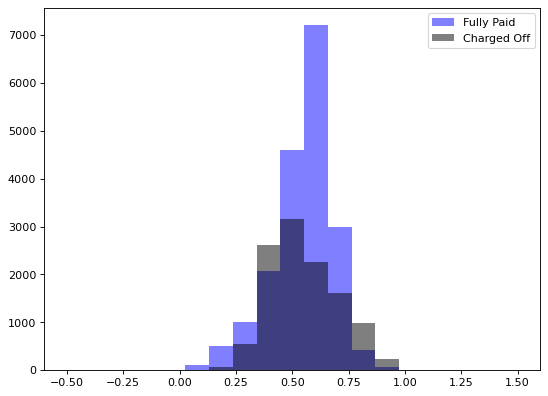

In [35]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
bins = np.linspace(-0.5, 1.5, 20)
plt.hist(subset_1, bins, color="b", alpha=0.5, label='Fully Paid')
plt.hist(subset_2, bins, color="k",alpha=0.5,label='Charged Off')
plt.legend(loc='upper right')
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test, y_pred)

array([[ 6589,  4896],
       [ 5544, 13437]], dtype=int64)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.54      0.57      0.56     11485
  Fully Paid       0.73      0.71      0.72     18981

    accuracy                           0.66     30466
   macro avg       0.64      0.64      0.64     30466
weighted avg       0.66      0.66      0.66     30466



#### A significantly better outcome for classification of Charged Off loans once numerical variables are scaled and sample imbalance is accounted for

## Explicit Oversampling of Charged Off Loans

In [39]:
pip install -U imbalanced-learn

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


In [38]:
# oversample charged off loans
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority')
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train.ravel())

In [39]:
target_values_dict = df['Loan Status'].value_counts().to_dict()

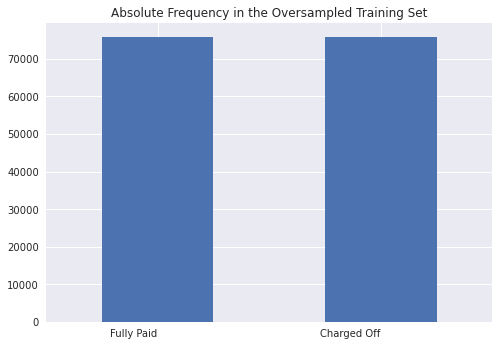

In [40]:
with plt.style.context('seaborn'):
    ax = pd.DataFrame(y_train_smote).value_counts().plot(kind='bar')
    ax.set_xticklabels(target_values_dict.keys(), rotation = 0, ha="right")
    ax.set_xlabel('')
    ax.set_title('Absolute Frequency in the Oversampled Training Set')

In [41]:
c_space = np.logspace(-5, 8, 15)
param_grid={'C': c_space, 'penalty':['l2']}
logreg = LogisticRegression(class_weight='balanced', max_iter=10000)
logreg_cv = GridSearchCV(logreg, param_grid, cv=5);
logreg_cv.fit(X_train, y_train);

In [44]:
print(f"Best CV Score {round(logreg_cv.best_score_, 4)}")

Best CV Score 0.6604


In [46]:
print(f"Best HyperParameter C: {round(logreg_cv.best_params_['C'],4)}")

Best HyperParameter C: 0.0007


In [48]:
y_pred = logreg_cv.best_estimator_.predict(X_test)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.54      0.57      0.56     11485
  Fully Paid       0.73      0.71      0.72     18981

    accuracy                           0.66     30466
   macro avg       0.64      0.64      0.64     30466
weighted avg       0.66      0.66      0.66     30466



In [51]:
confusion_matrix(y_test, y_pred)

array([[ 6589,  4896],
       [ 5544, 13437]], dtype=int64)

#### The explicit oversampling of the Charged Off loans did not change the result from the previous.

In [109]:
import shap
shap.initjs()

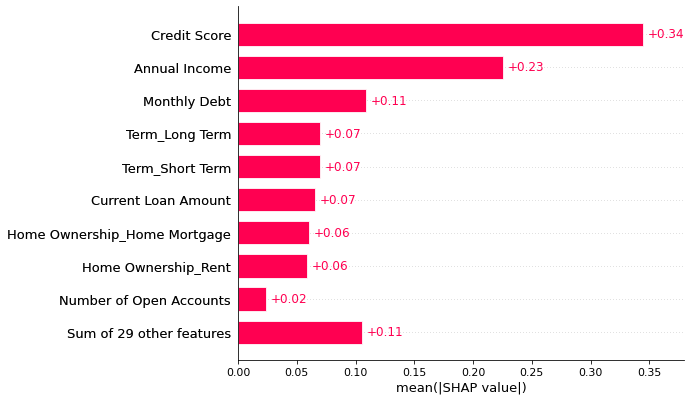

In [110]:
model = best_model
model.fit(X_train, y_train)

def model_proba(x):
    return model.predict_proba(x)[:,1]
def model_log_odds(x):
    p = model.predict_log_proba(x)
    return p[:,1] - p[:,0]

# compute SHAP values for linear
background = shap.maskers.Independent(X_train, max_samples=100)

# compute SHAP values
explainer = shap.Explainer(model, background)
shap_values = explainer(X_train)

shap.plots.bar(shap_values) # use mean absolute value of each feature over all the instances

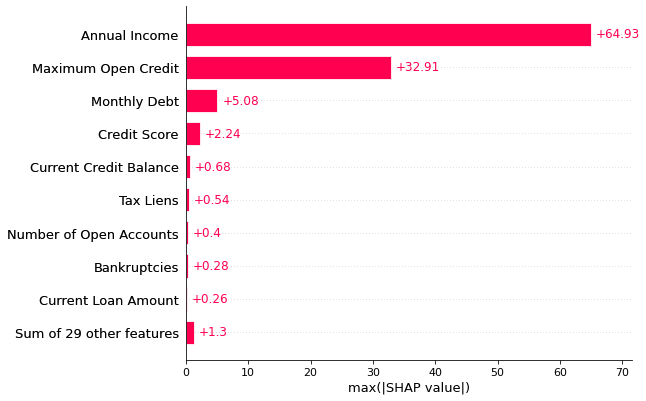

In [111]:
shap.plots.bar(shap_values.abs.max(0)) # use max absolute value 

## 3. Using only most important features

In [112]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152330 entries, 0 to 152329
Data columns (total 38 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Current Loan Amount             152330 non-null  float64
 1   Credit Score                    152330 non-null  float64
 2   Annual Income                   152330 non-null  float64
 3   Monthly Debt                    152330 non-null  float64
 4   Years of Credit History         152330 non-null  float64
 5   Number of Open Accounts         152330 non-null  float64
 6   Number of Credit Problems       152330 non-null  float64
 7   Current Credit Balance          152330 non-null  float64
 8   Maximum Open Credit             152330 non-null  float64
 9   Bankruptcies                    152330 non-null  float64
 10  Tax Liens                       152330 non-null  float64
 11  Term_Long Term                  152330 non-null  int64  
 12  Term_Short Term 

In [113]:
X=X.drop(['Credit Score', 'Number of Open Accounts', 'Number of Credit Problems','Maximum Open Credit','Bankruptcies', 'Tax Liens','Years in current job_1 year','Years in current job_10+ years','Years in current job_2 years','Years in current job_3 years','Years in current job_4 years','Years in current job_5 years','Years in current job_6 years','Years in current job_7 years','Years in current job_8 years','Years in current job_9 years','Years in current job_< 1 year'], axis=1)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
c_space = np.logspace(-5, 8, 15)
param_grid={'C': c_space, 'penalty':['l2']} # [l1,'l2']
logreg = LogisticRegression(class_weight='balanced',max_iter=10000)
logreg_cv = GridSearchCV(logreg, param_grid, cv=5);
logreg_cv.fit(X_train, y_train);

In [116]:
logreg_cv.best_params_

{'C': 0.05179474679231213, 'penalty': 'l2'}

In [117]:
logreg_cv.best_score_

0.627986943563782

In [118]:
best_model = logreg_cv.best_estimator_

In [119]:
y_pred = best_model.predict(X_test)

In [120]:
y_pred_proba=best_model.predict_proba(X_test)

In [121]:
# wrestle data to create plots:
# here I create two subsets of probabilities, one for cases that were 'Fully Paid' and 
# correctly identified as such, and one for 'Charged Off' and correctly identified as such
pred_proba_df=pd.DataFrame(data=y_pred_proba, columns=['Charged Off','Fully Paid'])
pred_proba_df['True']=y_test.values

subset_1=pred_proba_df[pred_proba_df['True']=='Fully Paid']['Fully Paid']
subset_2=pred_proba_df[pred_proba_df['True']=='Charged Off']['Charged Off']

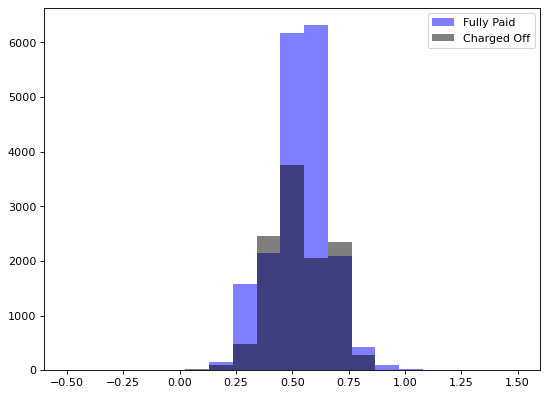

In [122]:
figure(figsize=(8, 6), dpi=80)
bins = np.linspace(-0.5, 1.5, 20)

plt.hist(subset_1, bins, color="b", alpha=0.5, label='Fully Paid')
plt.hist(subset_2, bins, color="k",alpha=0.5,label='Charged Off')
plt.legend(loc='upper right')
plt.show()

In [123]:
confusion_matrix(y_test, y_pred)

array([[ 6470,  5015],
       [ 6434, 12547]], dtype=int64)

In [124]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.50      0.56      0.53     11485
  Fully Paid       0.71      0.66      0.69     18981

    accuracy                           0.62     30466
   macro avg       0.61      0.61      0.61     30466
weighted avg       0.63      0.62      0.63     30466



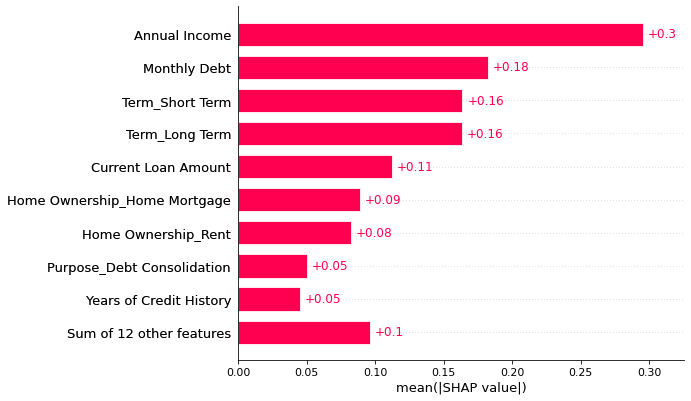

In [125]:
model = best_model
model.fit(X_train, y_train)

def model_proba(x):
    return model.predict_proba(x)[:,1]
def model_log_odds(x):
    p = model.predict_log_proba(x)
    return p[:,1] - p[:,0]

# compute SHAP values for linear
background = shap.maskers.Independent(X_train, max_samples=100)

# compute SHAP values
explainer = shap.Explainer(model, background)
shap_values = explainer(X_train)

shap.plots.bar(shap_values) # use mean absolute value of each feature over all the instances

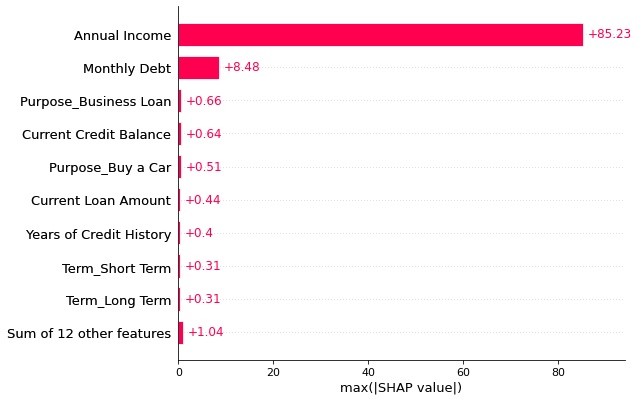

In [126]:
shap.plots.bar(shap_values.abs.max(0)) # use max absolute value 